In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from __future__ import annotations

# # debugging
# from jax.tree_util import tree_map
# import jax.tree_util

import os
import matplotlib.pyplot as plt
from typing import Tuple, Optional

plt.style.use('default')
from pathlib import Path
import sys
from dataclasses import dataclass, replace
sys.path.append(os.path.abspath('..'))
import time

import jax
import jax.numpy as jnp
jnp.set_printoptions(precision=6, suppress=True)
import numpy as np

from floris import FlorisModel, TimeSeries

# from diffwake.diffwake_jax.model import load_input, create_state
# from diffwake.diffwake_jax import model
# from diffwake.diffwake_jax.layout_runner import make_layout_runner
# from diffwake.diffwake_jax.util import average_velocity_jax
# from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
# from diffwake.diffwake_jax.simulator import simulate


# Wake model-agnostic edits to DiffWake
from diffwake.diffwake_jax.layout_runner_agnostic import make_layout_runner
from diffwake.diffwake_jax.model_agnostic import load_input, create_state, alter_yaw_angles
from diffwake.diffwake_jax.util_agnostic import average_velocity_jax, State, Result, set_cfg, Config
from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
from diffwake.diffwake_jax.sim_agnostic import simulate_simp, simulate
from wrapper import DiffWakeParams, DiffWakeSimulation, DiffWakeConfig


def absolute_percentage_difference(a, b):
    return jnp.abs((a - b) / b) * 100

# debugging helper
def check_types(x):
    print(f"Type: {type(x)}, value shape: {getattr(x, 'shape', 'N/A')}")
    return x

def set_dtype():
    return jnp.float64 if jax.config.x64_enabled else jnp.float32



Current floating point precision: <class 'jax.numpy.float64'>


In [4]:
data_dir = Path("data/horn")
cc_farm = "cc_hornsRev.yaml"
gch_farm = "gauss_hornsRev.yaml"
gen_file = "vestas_v802MW.yaml"

# Cartesian coordinates in metres
override_layout = False
layout_x = jnp.array([0.0, 500.0, 1000.0])
layout_y = jnp.array([0.0, 500.0, 1000.0])

# Inflow speed in m/s
wind_speed = jnp.array([13.5])
wind_dir = jnp.array([jnp.deg2rad(270.0)])
ti = jnp.array([0.06])

# Load configurations for each wake model
cc_config = DiffWakeConfig(data_dir, cc_farm, gen_file)
gch_config = DiffWakeConfig(data_dir, gch_farm, gen_file)


if override_layout == False:
    cc_params = DiffWakeParams(wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)
    gch_params = DiffWakeParams(wind_speed=wind_speed,
                                wind_directions=wind_dir,
                                turbulence_intensities=ti)

else:
    cc_params = DiffWakeParams(layout_x=layout_x,
                               layout_y=layout_y,
                               wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)
    gch_params = DiffWakeParams(layout_x=layout_x,
                               layout_y=layout_y,
                               wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)


# Prepare simulations
cc_sim = DiffWakeSimulation(cc_config, cc_params)
cc_state, cc_result, cc_runtime = cc_sim.run()
cc_farm_power = cc_sim.get_farm_power()

gch_sim = DiffWakeSimulation(gch_config, gch_params)
gch_state, gch_result, gch_runtime = gch_sim.run()
gch_farm_power = gch_sim.get_farm_power()


### FLORIS simulation & DiffWake comparisons

In [6]:
# Horns Rev 1 simulation
fmodel = FlorisModel(r"..\floris\examples\inputs\cc_vesta.yaml")

fmodel_gch = FlorisModel(r"..\floris\examples\inputs\gauss_vesta.yaml")

time_series = TimeSeries(
    wind_directions=np.array([270.0]),
    wind_speeds=np.array([13.5]),
    turbulence_intensities=0.06,
)

fmodel.set(wind_data=time_series)
cc_start_time = time.time()
fmodel.run()
cc_end_time = time.time()


fmodel_gch.set(wind_data=time_series)
gch_start_time = time.time()
fmodel_gch.run()
gch_end_time = time.time()

# FLORIS does not convert to MW automatically
gch_farm_power_floris = fmodel_gch.get_farm_power() / 1e6
gch_turbine_powers_floris = fmodel_gch.get_turbine_powers()
cc_farm_power_floris = fmodel.get_farm_power() / 1e6
cc_turbine_powers_floris = fmodel.get_turbine_powers()


# Set printing precision
print("---------- DiffWake JAX Results ----------")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_powers}")
print(f"Total farm power (MW): {gch_farm_power:.3f}")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_powers}")
print(f"Total farm power (MW): {cc_farm_power:.3f}")

print("\n---------- FLORIS Results ----------")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_turbine_powers_floris}")
print(f"Total farm power (MW): {gch_farm_power_floris[0]:.3f}")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_turbine_powers_floris}")
print(f"Total farm power (MW): {cc_farm_power_floris[0]:.3f}")

print("\n---------- Differences ----------")
print(f"Absolute farm power difference (GCH) = {absolute_percentage_difference(gch_farm_power_floris, gch_farm_power)[0]:.2f}%")
print(f"Absolute farm power difference (CC) = {absolute_percentage_difference(cc_farm_power_floris, cc_farm_power)[0]:.2f}%")


---------- DiffWake JAX Results ----------
Total farm power (MW): 142.646
Total farm power (MW): 97.611

---------- FLORIS Results ----------
Total farm power (MW): 142.661
Total farm power (MW): 97.540

---------- Differences ----------
Absolute farm power difference (GCH) = 0.01%
Absolute farm power difference (CC) = 0.07%


In [7]:
print("------------ FLORIS runtimes ------------")
print(f"Cumulative-Curl: {cc_end_time - cc_start_time:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_end_time - gch_start_time:.4f}s")

print("\n------------ DiffWake runtimes ------------")
print(f"Cumulative-Curl: {cc_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")

------------ FLORIS runtimes ------------
Cumulative-Curl: 0.1869s
Gauss-Curl Hybrid: 0.1247s

------------ DiffWake runtimes ------------
Cumulative-Curl: 4.9880s
Gauss-Curl Hybrid: 1.9130s


## jax.lax

Because the problem is relatively simple, we will now compare multi-direction and speed simulations to see if JAX provides an improvement.

DiffWake having a longer runtime is expected due to the relatively simple nature of the problem; the overheads are non-trivial.

There are options like lax.scan and lax.fori_loop but they serve different purposes.

Here we test simple simulations using lax.fori_loop since the history isn't stored.

If we wanted to store history and use reverse-mode automatic differentiation, we would most definitely switch to lax.scan which is not implemented in DiffWake as of now.


In [23]:
# # Run using lax_fori
cc_lax_start = time.time()
cc_sim.run(scan=True)
cc_lax_end = time.time()

gch_lax_start = time.time()
gch_sim.run(scan=True)
gch_lax_end = time.time()

cc_lax_runtime = cc_lax_end - cc_lax_start
gch_lax_runtime = gch_lax_end - gch_lax_start

print("------------ FLORIS runtimes ------------")
print(f"Cumulative-Curl: {cc_end_time - cc_start_time:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_end_time - gch_start_time:.4f}s")


print("\n------------ DiffWake runtimes (simple for-loop) ------------")
print(f"Cumulative-Curl: {cc_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")

print("\n------------ DiffWake runtimes (lax fori_loop) ------------")
print(f"Cumulative-Curl: {cc_lax_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_lax_runtime:.4f}s")

# Power results verification using lax fori
cc_lax_farm_power = cc_sim.get_farm_power()
gch_lax_farm_power = gch_sim.get_farm_power()

print("\n------------ DiffWake powers (jax.lax.fori_loop) ------------")
print(f"Total farm power (MW): {cc_lax_farm_power:.3f}")
print(f"Total farm power (MW): {gch_lax_farm_power:.3f}")


------------ FLORIS runtimes ------------
Cumulative-Curl: 0.1906s
Gauss-Curl Hybrid: 0.1233s

------------ DiffWake runtimes (simple for-loop) ------------
Cumulative-Curl: 1.2750s
Gauss-Curl Hybrid: 1.1388s

------------ DiffWake runtimes (lax fori_loop) ------------
Cumulative-Curl: 0.5146s
Gauss-Curl Hybrid: 0.5396s

------------ DiffWake powers (jax.lax.fori_loop) ------------
Total farm power (MW): 97.611
Total farm power (MW): 142.646


These results are a good start. Although it is just a simple 80-turbine simulation of the Horns Rev 1 farm, we can see how running lax.fori_loop (similar to a C-style loop) can increase the runtime performance significantly.

We can increase performance further by using vmap (vectorised mapping) to process simulations in batches.

### FLORIS vs DiffWake (using vectorised mapping)
Let's run through GCH and CC simulations using FLORIS and DiffWake to see the performance improvements.
The JAX-based implementations of GCH and CC should both yield linear runtimes whereas the FLORIS implementation of CC should lead to a runtime that varies quadratically with the number of turbines N (due to the nested loop). The FLORIS GCH implementation should be linear, since it only loops through the turbines once.
### 360 unique wind directions and 16  unique wind speeds using FLORIS and DiffWake
#### JAX

In [17]:
farm_powers = []
turbine_powers = []

# Conditions we want to test
wind_speeds = jnp.arange(2.0, 18.0, 1.0)
wind_directions = jnp.arange(0.0, 360.0, 1.0)
ti_table = 0.06

# Permutation grid of wind conditions
ws_grid, wd_grid = jnp.meshgrid(wind_speeds, wind_directions, indexing="ij")

ws_flat = ws_grid.flatten()
wd_flat = wd_grid.flatten()
ti_flat = jnp.full_like(ws_flat, ti_table)

gch_profile_cfg = load_input(farm_path=data_dir / gch_farm,
                     generator_path=data_dir / gen_file)

cc_profile_cfg = load_input(farm_path=data_dir / cc_farm,
                            generator_path=data_dir / gen_file)

# To fix this JIT, config has to be a static type since the base doesn't change, but the flow-field does change.
# Wrapper function to wrap in vmap
def run_single_case(ws: float,
                    wd: float,
                    ti: float,
                    input):

    ws_arr = jnp.array([ws])
    wd_arr = jnp.array([wd])
    ti_arr = jnp.array([ti])

    cfg = input.set(
        wind_speeds=ws_arr,
        wind_directions=wd_arr,
        turbulence_intensities=ti_arr,
    )

    state = create_state(cfg)

    return simulate(state)

cc_vmap = jax.vmap(run_single_case, in_axes=(0, 0, 0, None))
gch_vmap = jax.vmap(run_single_case, in_axes=(0, 0, 0, None))

start_time = time.time()
gch_vmap_results = gch_vmap(ws_flat, wd_flat, ti_flat, gch_profile_cfg).turb_u_wake.block_until_ready()
end_time = time.time()
gch_vmap_runtime = end_time - start_time
print(f"GCH (vmap only) runtime: {gch_vmap_runtime:.4f}s")

start_time = time.time()
cc_vmap_results = cc_vmap(ws_flat, wd_flat, ti_flat, cc_profile_cfg).turb_u_wake.block_until_ready()
end_time = time.time()
cc_vmap_runtime = end_time - start_time
print(f"CC (vmap only) runtime: {cc_vmap_runtime:.4f}s")

E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\interpreters\mlir.py:1274: UserWarning: Some donated buffers were not usable: float32[1,80,3,3], float32[1,80,3,3], float32[1,80,3,3].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


GCH (vmap only) runtime: 9.9219s


E:\Aeronautics\FYP\.venv\Lib\site-packages\jax\_src\interpreters\mlir.py:1274: UserWarning: Some donated buffers were not usable: float32[1,80,3,3], float32[1,80,3,3], float32[1,80,3,3], float32[80,1,80,3,3], float32[1,80,1,1].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


CC (vmap only) runtime: 52.7290s


##### Vectorised mapping (without JIT)

##### Vectorised mappnig with JIT

The first run should be longer than subsequent runs since it has a compile time.

In [15]:
# print(f"GCH vmap time per simulation: {(gch_vmap_runtime/ws_flat.shape[0]):.4f}s")
# print(f"CC vmap time per simulation: {(cc_vmap_runtime/wd_flat.shape[0]):.4f}s")
#
# jitted_cc = jax.jit(cc_vmap)
# jitted_gch = jax.jit(gch_vmap)
#
# # Compilation run
# start_time = time.time()
# gch_jit_results = jitted_gch(ws_flat, wd_flat, ti_flat, gch_profile_cfg).turb_u_wake.block_until_ready()
# end_time = time.time()
# gch_jit_first_runtime = end_time - start_time
# print(f"JIT vmap runtime (first run including compile time): {gch_jit_first_runtime:.4f}s")
#
# # Post-compilation run
# start_time = time.time()
# gch_jit_results_again = jitted_gch(ws_flat, wd_flat, ti_flat, cc_profile_cfg).turb_u_wake.block_until_ready()
# end_time = time.time()
# gch_jit_runtime_again = end_time - start_time
# print(f"JIT vmap runtime (second run after compilation has finished: {gch_jit_runtime_again:.4f}s)")
#
# # Check results are the same
# print(f"Results match: {jnp.allclose(gch_jit_results, gch_vmap_results)}")


## Numerical precision tests
Physical simulations require accuracy but there can be a big runtime tradeoff when switching between FP16, FP32 and FP64 precision.
Let's use 4 cases:
1. A row of 3 turbines at x = [0.0, 400.0, 800.0], unyawed
2. A row of 3 turbines at x = [0.0, 400.0, 800.0], yawed at [20.0, 10.0, 0.0]
3. Horns Rev 1, unyawed
4. Horns Rev 1, all yawed at 10 degrees except the most downstream row, which is left unyawed.

All cases have the same wind speed, wind direction and turbulence intensity.

In [70]:
wake_model = "gauss"
data_dir = Path("data/horn")
farm_cfg_path = data_dir / f"{wake_model}_hornsRev.yaml"
turbine_cfg_path = data_dir / "vestas_v802MW.yaml"


# Set FP64
# Enable x64 on JAX if possible
jax.config.update("jax_enable_x64", True)
DTYPE = set_dtype()
print(f"Current floating point precision: {DTYPE}")

# Base configuration (unyawed)
cfg = load_input(farm_cfg_path, turbine_cfg_path)
ws_test = 13.5
wd_test = 270.0
ti_val_test = 0.06
layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)
wind_speed = jnp.array([ws_test], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd_test)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val_test], dtype=DTYPE)

def run_configuration(base_config: Config,
                      ws: jnp.ndarray,
                      wd: jnp.ndarray,
                      ti_val: jnp.ndarray,
                      layout: Tuple[jnp.ndarray, jnp.ndarray] = (None, None),
                      yaw_angles: jnp.ndarray = None):
    if None in layout:
        test_config = base_config.set(
            wind_speeds=ws,
            wind_directions=wd,
            turbulence_intensities=ti_val,
        )
    else:
        test_config = base_config.set(
            layout_x=layout[0],
            layout_y=layout[1],
            wind_speeds=ws,
            wind_directions=wd,
            turbulence_intensities=ti_val,
        )

    test_state = create_state(test_config)

    if yaw_angles is not None:
        test_state_yawed = alter_yaw_angles(yaw_angles, test_state)
        time_start = time.time()
        test_result = simulate(test_state_yawed)
        time_end = time.time()
        tp = power_fn(power_thrust_table=test_state_yawed.farm.power_thrust_table,
                                      velocities=test_result.u_sorted,
                                      air_density=test_state_yawed.flow.air_density,
                                      yaw_angles=test_state_yawed.farm.yaw_angles)
    else:
        time_start = time.time()
        test_result = simulate(test_state)
        time_end = time.time()
        tp = power_fn(power_thrust_table=test_state.farm.power_thrust_table,
                                      velocities=test_result.u_sorted,
                                      air_density=test_state.flow.air_density,
                                      yaw_angles=test_state.farm.yaw_angles)



    # Watts
    farm_power = jnp.sum(tp)

    return test_result, tp, farm_power, time_end - time_start

Current floating point precision: <class 'jax.numpy.float64'>


In [71]:
# ENABLE X64 AND VERIFY DTYPE IS FP64
print(f"x64 enabled: {jax.config.x64_enabled}")

def run_all_cases():
    # Cases 1 and 2
    case1 = run_configuration(cfg, wind_speed, wind_dir, ti, layout=(layout_x, layout_y))
    case2 = run_configuration(cfg, wind_speed, wind_dir, ti, layout=(layout_x, layout_y), yaw_angles=jnp.deg2rad(jnp.array([[20.0, 10.0, 0.0]])))

    # Cases 3 and 4
    hr1_yaw = jnp.deg2rad(jnp.array([jnp.concatenate([jnp.full(70, 10.0), jnp.zeros(10)])]))
    case3 = run_configuration(cfg, wind_speed, wind_dir, ti)
    case4 = run_configuration(cfg, wind_speed, wind_dir, ti, yaw_angles=hr1_yaw)

    rt_1.append(case1[3])
    rt_2.append(case2[3])
    rt_3.append(case3[3])
    rt_4.append(case4[3])

    return case1, case2, case3, case4, rt_1, rt_2, rt_3, rt_4

# Get the average runtime for all cases over 50 runs
N_runs = 50

# Tracking runtimes
rt_1 = []
rt_2 = []
rt_3 = []
rt_4 = []

for i in N_runs:
    c1_fp64, c2_fp64, c3_fp64, c4_fp64 = run_all_cases()

    # Append all runtimes and get the average
    rt_1.append(c1_fp64[3])
    rt_2.append(c2_fp64[3])
    rt_3.append(c3_fp64[3])
    rt_4.append(c4_fp64[3])

# verify dtype
cases_fp64[0][0].turb_u_wake.dtype, cases_fp64[0][0].u_sorted.dtype

x64 enabled: True


(dtype('float64'), dtype('float64'))

In [72]:
# Disable X64
jax.config.update("jax_enable_x64", False)
jax.config.x64_enabled
DTYPE = set_dtype()
print(f"DTYPE: {DTYPE}")

# Override DTYPEs
ws_test = 13.5
wd_test = 270.0
ti_val_test = 0.06
layout_x = jnp.array([0.0, 400.0, 800.0], dtype=DTYPE)
layout_y = jnp.array([0.0, 0.0, 0.0], dtype=DTYPE)
wind_speed = jnp.array([ws_test], dtype=DTYPE)
wind_dir = jnp.array([jnp.deg2rad(wd_test)], dtype=DTYPE) # Wind from West
ti = jnp.array([ti_val_test], dtype=DTYPE)

cases_fp32 = run_all_cases()
# verify dtype
cases_fp32[0][0].turb_u_wake.dtype, cases_fp32[0][0].u_sorted.dtype

DTYPE: <class 'jax.numpy.float32'>


(dtype('float32'), dtype('float32'))

In [73]:
print(f"--- FP64 runtimes ---")
print(f"Case 1: {cases_fp64[0][3]:.8f}s")
print(f"Case 2: {cases_fp64[1][3]:.8f}s")
print(f"Case 3: {cases_fp64[2][3]:.8f}s")
print(f"Case 4: {cases_fp64[3][3]:.8f}s")

print(f"--- FP32 runtimes ---")
print(f"Case 1: {cases_fp32[0][3]:.8f}s")
print(f"Case 2: {cases_fp32[1][3]:.8f}s")
print(f"Case 3: {cases_fp32[2][3]:.8f}s")
print(f"Case 4: {cases_fp32[3][3]:.8f}s")

--- FP64 runtimes ---
Case 1: 0.46967506s
Case 2: 0.87606740s
Case 3: 0.47840714s
Case 4: 0.46042538s
--- FP32 runtimes ---
Case 1: 0.56708097s
Case 2: 0.54557872s
Case 3: 0.53455114s
Case 4: 0.52321124s


Text(0.5, 1.0, 'Percentage difference between JAX & FLORIS farm powers')

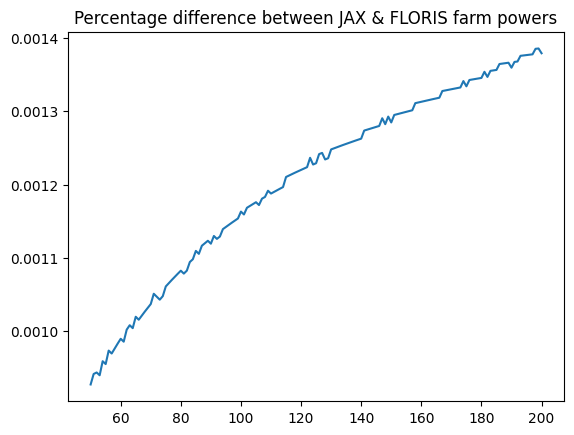

In [23]:
plt.plot(N_turbines, diff)
plt.title("Percentage difference between JAX & FLORIS farm powers")

In [27]:
print(f"FLORIS runtime (seconds): {floris_runtime:.4f}")
print(f"JAX runtime using vmap (seconds): {(end_time - start_time):.4f}")
print(f"Speed increase: {floris_runtime/(end_time - start_time):.4f}")

FLORIS runtime (seconds): 107.0629
JAX runtime using vmap (seconds): 17.6262
Speed increase: 6.0741
